In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [4]:
drugbank_input = Chem.SDMolSupplier('../data/drugbank.sdf')
drugbank = [m for m in drugbank_input if m]

In [7]:
drugbank_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=512) for m in drugbank]

In [11]:
first = drugbank_fps[0]
first.ToBitString()

'01001000100000000001000000001000010000010110000000000000000001001010000000000001101100101000001000000000000010011000010000000000100000000010100100010000100100000000000010000101010100010000000001001100010000000000001000110000100100000100000000100001010000000000000100100100001000000001000101000011000001000000101101000001000001000000000001001000010000000010100001110000010000011000011000000100000000100000000001000011100000010001000000000000010100100000000010100000010000110000000010001000100000000000000001110010'

# Pravděpodobnostní vyhledávání


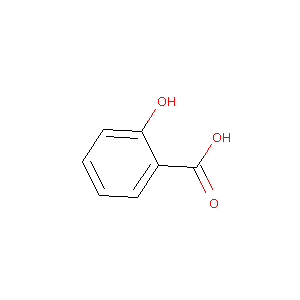

In [12]:
from rdkit import DataStructs
salicylica = Chem.MolFromSmiles("c1ccc(c(c1)C(=O)O)O")
Draw.MolToImage(salicylica)

In [13]:
salicylica_fp = AllChem.GetMorganFingerprintAsBitVect(salicylica, 2, nBits=512)
salicylica_fp.ToBitString()

'00000000000000000000000100000000000000000000000000000000000000001010000100000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000001000000000001000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000001000000000000000000100000000000000000000000010000000100000000000000000000000000000000010000000000000000000000000000000110000000000000000000000000000000000000010000000000000000'

In [16]:
salicylica_similarities = [DataStructs.FingerprintSimilarity(salicylica_fp, fp) for fp in drugbank_fps]
min(salicylica_similarities), max(salicylica_similarities), sum(salicylica_similarities)/len(salicylica_similarities)

(0.0, 1.0, 0.1337547673692333)

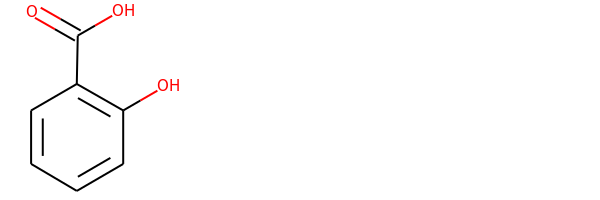

In [20]:
hit_indexes = [i for i, similarity in enumerate(salicylica_similarities) if similarity >= 1.0]
Draw.MolsToGridImage([drugbank[i] for i in hit_indexes])

In [22]:
bit_aggregation = [0]*512
for fp in drugbank_fps:
    for bit in fp.GetOnBits():
        bit_aggregation[bit] += 1

In [33]:
least_set_amount = min(bit_aggregation)
least_set_index = bit_aggregation.index(least_set_amount)
most_set_amount = max(bit_aggregation)
most_set_index = bit_aggregation.index(most_set_amount)
least_set_amount, least_set_index, most_set_amount, most_set_index


(96, 174, 5667, 356)

In [48]:
def hit2smiles(hit, mol):
    atomid, radius = hit
    if radius > 0:
        hit_atoms = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atomid)
        submol = Chem.PathToSubmol(mol, hit_atoms)
        return Chem.MolToSmiles(submol)
    else:
        return mol.GetAtomWithIdx(atomid).GetSymbol()

In [49]:
def mol2fragments(mol):
    bitinfo = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512, bitInfo=bitinfo)
    fragments = {bit: [hit2smiles(hit, mol) for hit in hits]
                 for bit, hits in bitinfo.items()}
    return fragments

In [57]:
def explain_bit(bit, molecules):
    fragments = {}
    for mol in drugbank:
        molecule_fragments = mol2fragments(mol)
        if bit in molecule_fragments:
            for smiles in molecule_fragments[bit]:
                fragments[smiles] = fragments.get(smiles, 0) + 1
    return fragments

In [53]:
mol2fragments(salicylica)

{23: ['cc(c)C(=O)O'],
 64: ['ccc', 'ccc'],
 66: ['cO'],
 71: ['cc(c)O'],
 138: ['O'],
 175: ['ccccc', 'ccccc'],
 187: ['ccc(O)c(c)C'],
 214: ['ccc', 'ccc'],
 295: ['C', 'O', 'O', 'cccc(c)O'],
 337: ['C', 'C', 'C', 'C'],
 356: ['C', 'C'],
 381: ['C=O'],
 389: ['CO'],
 423: ['cccc(c)C'],
 455: ['cc(c)C'],
 456: ['cC(=O)O'],
 495: ['ccc(C(=O)O)c(c)O']}

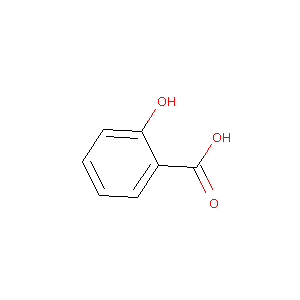

In [54]:
Draw.MolToImage(salicylica)

In [58]:
fragments = explain_bit(356, drugbank)

In [59]:
fragments

{'C': 26482,
 'C=CCC(C)[NH3+]': 2,
 'C=Cc(cc)nc': 1,
 'C=Cc(cc)sc': 2,
 'C=Cc(n)n': 1,
 'C=NC(N)=NC': 2,
 'CC(=O)NC(C)C': 8,
 'CC(C)(C)CC(C)(C)O': 1,
 'CC(C)(c)CC[NH3+]': 1,
 'CC(C)=CC(C)O': 1,
 'CC(C)CC(C)N': 1,
 'CC(C)CC(C)O': 1,
 'CC(C)O': 106,
 'CC(N)C(=O)N(C)C': 1,
 'CC(O)C(C)C(c)O': 1,
 'CCC(C)C(=O)O': 1,
 'CCC(CC)C(C)C': 2,
 'CCC(CN)NC': 1,
 'CCC(O)C(C)N': 3,
 'CCCC(C)N': 9,
 'CCSC(C)N': 1,
 'CCc': 1,
 'CN(c)C(=O)C(C)(C)N': 1,
 'CP(=O)(O)OP(=O)(O)O': 3,
 'Ca': 1,
 'cCC': 4,
 'cN=C(CN)CO': 1,
 'cNC(=O)C(C)N': 1,
 'cc(-c)sc(c)Br': 1,
 'cc(C)c(C(C)=O)c(c)O': 1,
 'cc(C)c(C(N)=O)c(c)N': 1,
 'cc(C)c[n+](c)C': 10,
 'cc(C)o': 1,
 'cc(N)nc(c)O': 1,
 'cc(c)-c(c(c)[nH])c(c)[nH]': 1,
 'cc(c)C(CC)(C(C)=O)c(c)c': 1,
 'cc(c)C(Cc)c(c)n': 1,
 'cc(c)O[Bi](O)O': 1,
 'cc(c)nc([nH])N': 1,
 'cc(n)[O-]': 2,
 'ccc(-c(c)c)c(-c)n': 2,
 'ccc(Br)c(c)O': 2,
 'ccc(C)c(c)N': 1,
 'ccc(OC)c(c)C': 6,
 'ccc(OC)c(c)O': 84,
 'ccc(OC)c(c)c': 1,
 'ccc(Oc)c(c)N': 2,
 'ccc(c(c)s)[n+](c)[O-]': 1,
 'cccc(C)n': 1,
 'cccsc